In [2]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
#     from skimage.exposure import exposure
#     p2, p98 = np.percentile(im, (2, 98))
#     im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
#     pyh = np.abs(pyh)
    pyh = pyh * np.conjugate(pyh)
#     pyh = pyh / pyh.max()
    return pyh.real

    a = 20 * np.log10(pyh 
#                       + 0.0000000000000000000001
                     ) # add small number to avoid div by 0
    return a


from pyha import Hardware, simulate, sims_close, Complex, Sfix, scalb

results = {}
import pickle

In [3]:
# SNR: 27.808717953912666 (full prec)
# SNR: 27.934033216930448 (10 twid, 8 window)
# SNR: 27.42276405103311 (9 twid, 8 window)

In [4]:
with open('/home/gaspar/Documents/low_power_ph3.raw_spectro.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

<IPython.core.display.Javascript object>


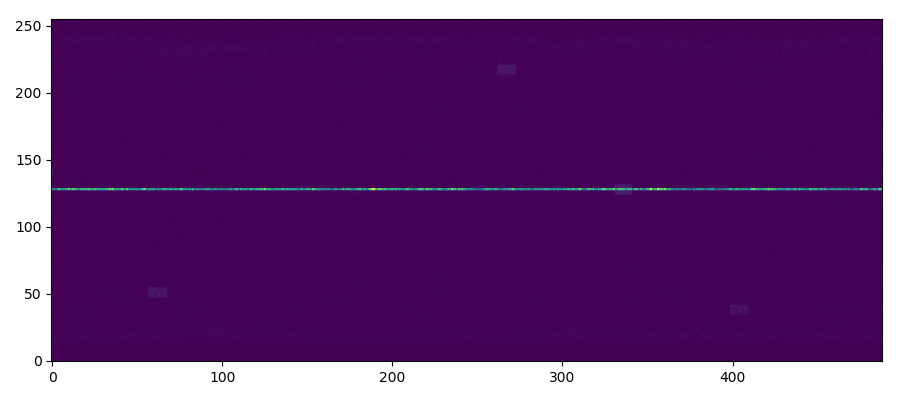

In [5]:
imshow(np.array(data['MODEL']).T)

In [13]:
m = np.array(data['MODEL']).T
m = m / m.max()
print(m.shape)
p = np.array(data['PYHA']).T
p = p / p.max()

print(p.shape)
print(snr(m[0], p[0][:-1]))

(256, 488)
(256, 489)
15.508344502980469


In [6]:
plt.plot(m[0])
plt.plot(p[0])
plt.show()

NameError: name 'm' is not defined

<IPython.core.display.Javascript object>


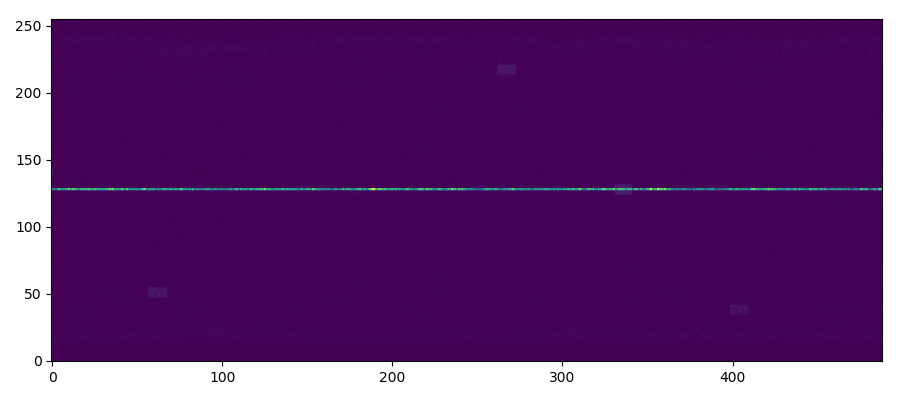

In [7]:
plt.imshow(np.array(data['MODEL']).T, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


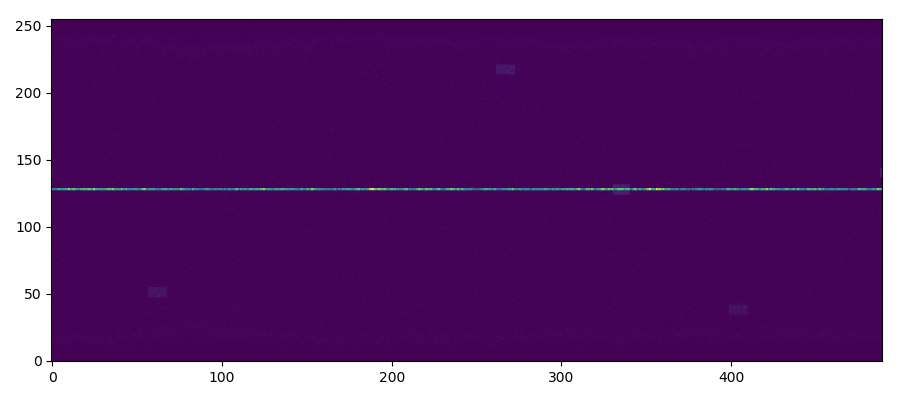

In [11]:
plt.imshow(np.array(data['PYHA']).T, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


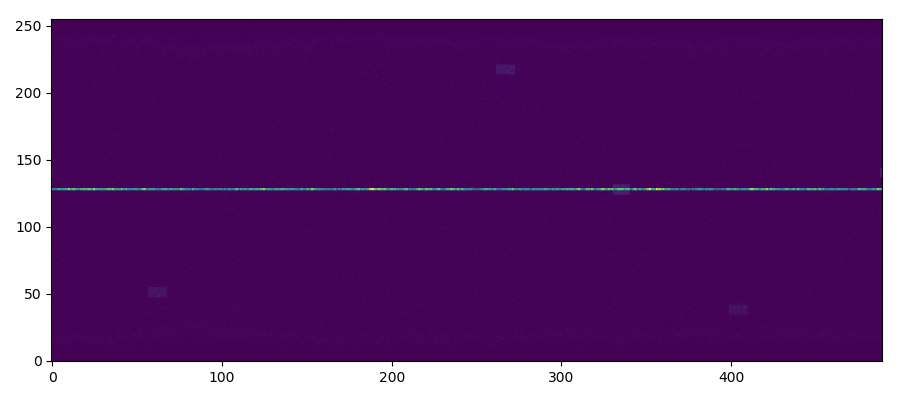

In [8]:
imshow(np.array(data['PYHA']).T)

In [12]:
WINDOW_LEN = 512
def ma(inputs):
    # MA expressed as FIR filter
    taps = [1 / WINDOW_LEN] * WINDOW_LEN
    return signal.lfilter(taps, [1.0], inputs)

In [13]:
file = '/home/gaspar/Documents/low_power_ph3.raw'
fft_size = 1024 * 2 * 2 * 2
decimation = 32
print(file)

iq = load_iq(file)

/home/gaspar/Documents/low_power_ph3.raw


In [14]:
avg = ma(ma(ma(ma(iq))))

In [15]:
delay = WINDOW_LEN * 4
dc_rem = iq[delay:] - avg[:-delay]

<IPython.core.display.Javascript object>


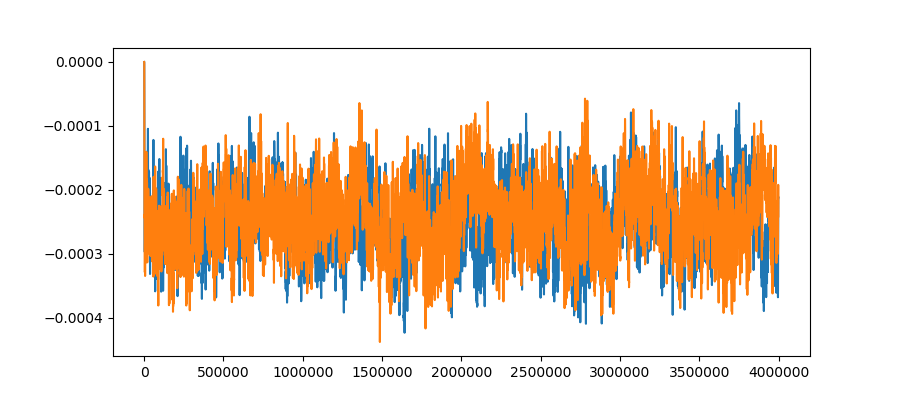

In [17]:
plt.plot(avg.real)
plt.plot(avg.imag)
plt.show()

1.22062642769257e-06 6.215214851214261e-06


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


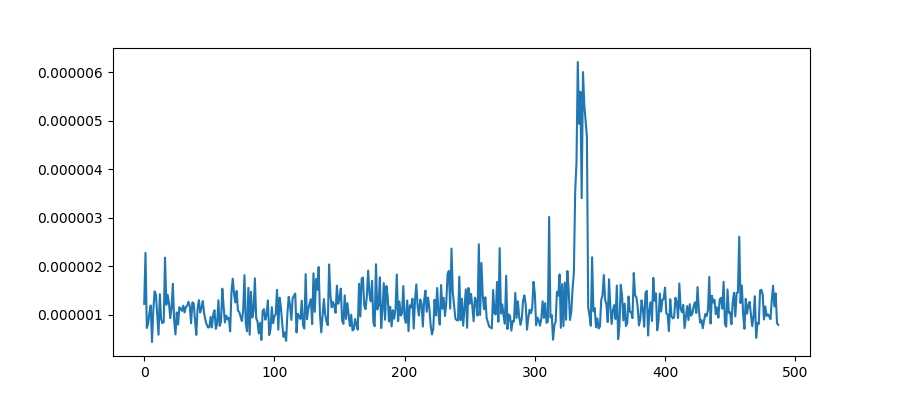

<IPython.core.display.Javascript object>


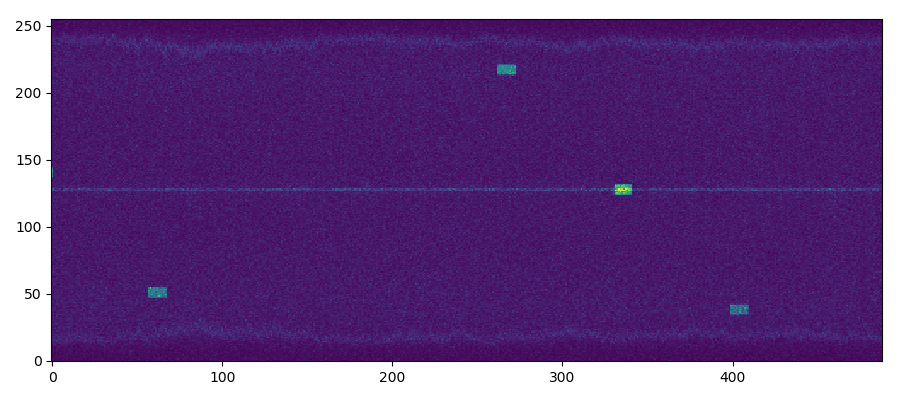

<IPython.core.display.Javascript object>


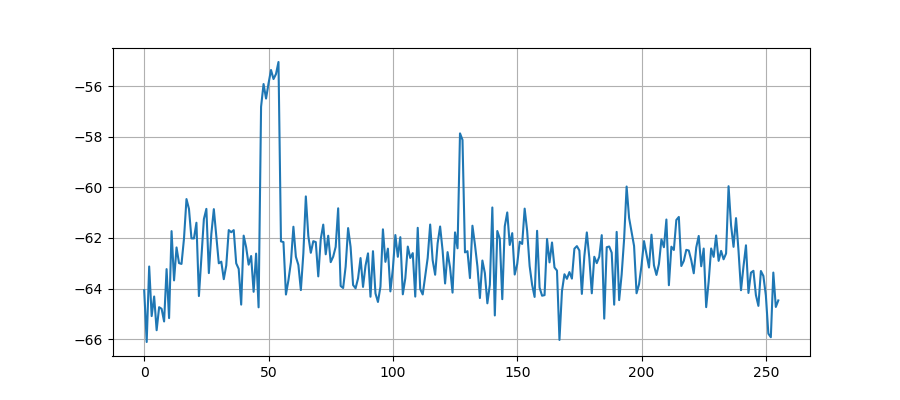

In [146]:
NFFT = 1024 * 8
DECIMATE_BY = 32
_, _, spectro_out = signal.spectrogram(iq - avg, 1, nperseg=NFFT, return_onesided=False, detrend=False,
                                       noverlap=0, window='hanning')

# fftshift
shifted = np.roll(spectro_out, NFFT // 2, axis=0)

# # avg decimation
l = np.split(shifted, len(shifted) // DECIMATE_BY)
golden_output = np.average(l, axis=1)


print(np.mean(golden_output[128]), np.max(golden_output[128]))
plt.plot(golden_output[128])
plt.show()

imshow(golden_output)

plt.plot(np.log10(golden_output.T[60]) * 10)
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.4851045461461172e-06 7.25689003618806e-06


<IPython.core.display.Javascript object>


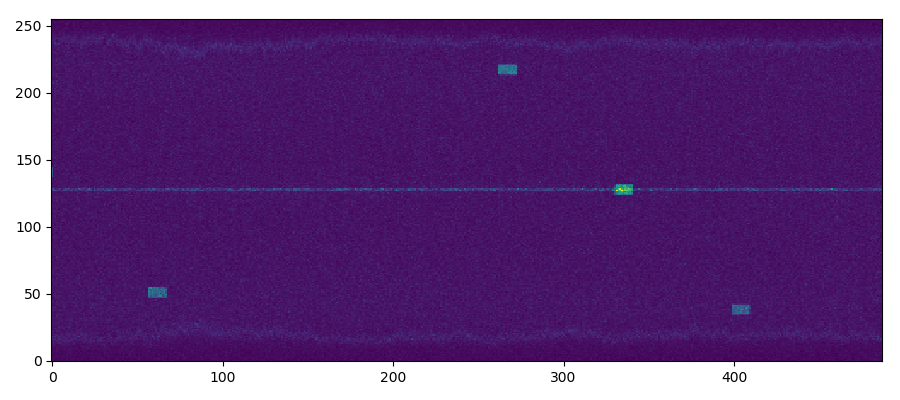

<IPython.core.display.Javascript object>


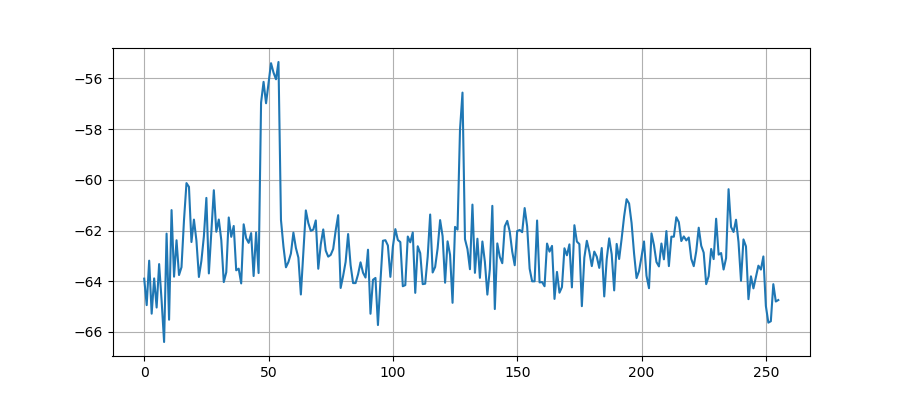

In [140]:
NFFT = 1024 * 8
DECIMATE_BY = 32
_, _, spectro_out = signal.spectrogram(dc_rem, 1, nperseg=NFFT, return_onesided=False, detrend=False,
                                       noverlap=0, window='hanning')

# fftshift
shifted = np.roll(spectro_out, NFFT // 2, axis=0)

# # avg decimation
l = np.split(shifted, len(shifted) // DECIMATE_BY)
golden_output = np.average(l, axis=1)


print(np.mean(golden_output[128]), np.max(golden_output[128]))
imshow(golden_output)

plt.plot(np.log10(golden_output.T[60]) * 10)
plt.grid()
plt.show()

1.7776244e-06 6.0041452e-06


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


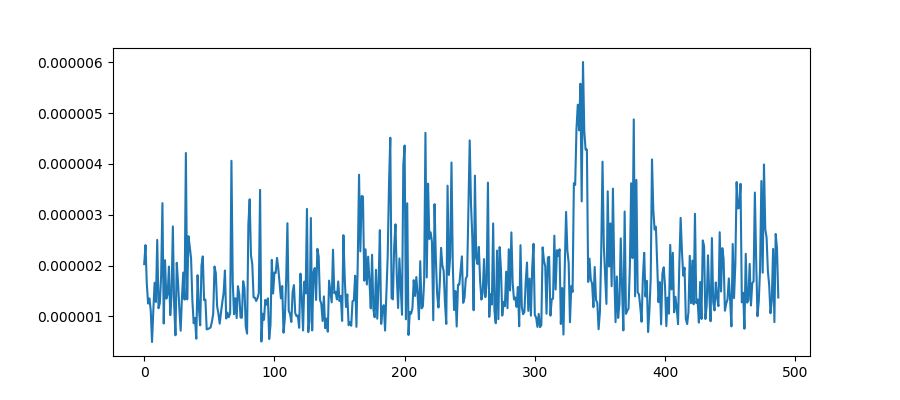

<IPython.core.display.Javascript object>


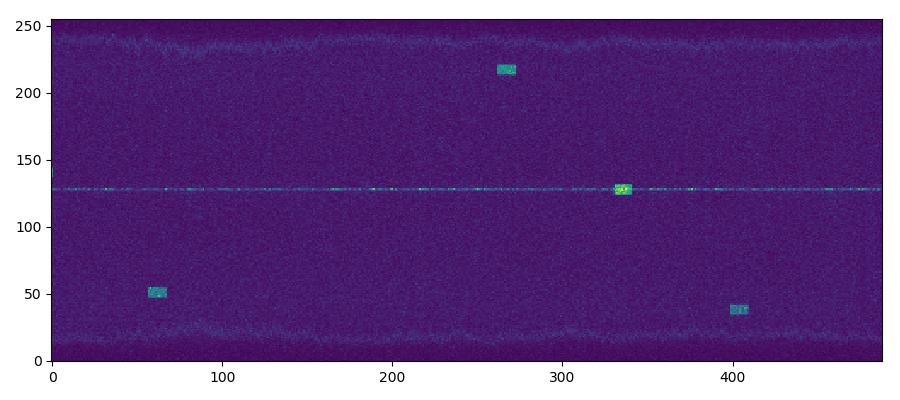

<IPython.core.display.Javascript object>


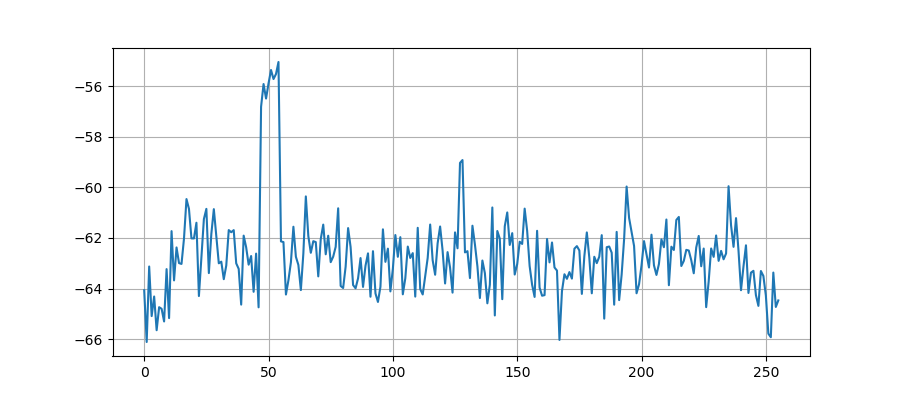

In [129]:
NFFT = 1024 * 8
DECIMATE_BY = 32
_, _, spectro_out = signal.spectrogram(iq - np.mean(iq), 1, nperseg=NFFT, return_onesided=False, detrend=False,
                                       noverlap=0, window='hanning')

# fftshift
shifted = np.roll(spectro_out, NFFT // 2, axis=0)

# # avg decimation
l = np.split(shifted, len(shifted) // DECIMATE_BY)
golden_output = np.average(l, axis=1)

print(np.mean(golden_output[128]), np.max(golden_output[128]))
plt.plot(golden_output[128])
plt.show()


imshow(golden_output)

plt.plot(np.log10(golden_output.T[60]) * 10)
plt.grid()
plt.show()

